In [2]:
import pandas as pd
import numpy as np 

In [6]:
df_normalized = pd.read_csv('processed_data.csv')

In [8]:
from sklearn.model_selection import train_test_split
#let's make a train/test split

X = df_normalized.drop('loan_status', axis=1)
y = df_normalized['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Raw dataset class distribution:")
print(y.value_counts(normalize=True))

print("\nTrain class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest Class distribution:")
print(y_test.value_counts(normalize=True))

Raw dataset class distribution:
loan_status
0    0.78182
1    0.21818
Name: proportion, dtype: float64

Train class distribution:
loan_status
0    0.781803
1    0.218197
Name: proportion, dtype: float64

Test Class distribution:
loan_status
0    0.781888
1    0.218112
Name: proportion, dtype: float64


First, let's try to train a simple logistic regression.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

log_reg = LogisticRegression(
    class_weight='balanced',  
    max_iter=1000,           
    random_state=42,
    solver='lbfgs'           
)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]  # default probability

# model evaluation
print("\n" + "="*50)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))

print("\nROC-AUC Score: {:.3f}".format(roc_auc_score(y_test, y_pred_proba)))





Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.92      0.80      0.86      5094
     Default       0.51      0.77      0.61      1421

    accuracy                           0.79      6515
   macro avg       0.72      0.78      0.74      6515
weighted avg       0.83      0.79      0.80      6515


ROC-AUC Score: 0.860


Let's check a confusion matrix

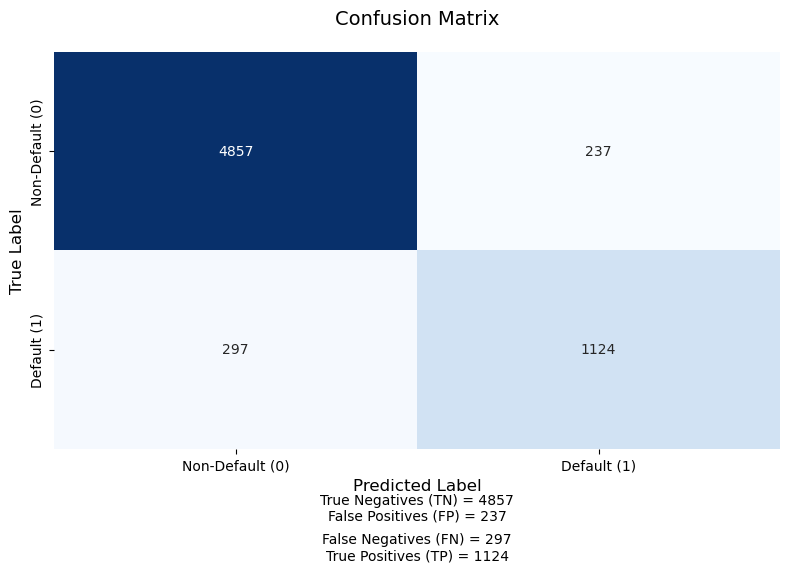

In [53]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=['Non-Default (0)', 'Default (1)'], 
            yticklabels=['Non-Default (0)', 'Default (1)'])

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, pad=20)

plt.text(0.5, -0.15, 
         f'True Negatives (TN) = {cm[0,0]}\nFalse Positives (FP) = {cm[0,1]}',
         ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.25, 
         f'False Negatives (FN) = {cm[1,0]}\nTrue Positives (TP) = {cm[1,1]}',
         ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

While the model's high default detection rate (77% recall) effectively prevents costly bad loans - a priority for risk management - its high false positive rate wastes revenue opportunities. Fine-tuning the model could maintain strong risk prevention while increasing approval rates for qualified borrowers, creating a better risk-reward balance

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

rf = RandomForestClassifier(
    class_weight='balanced_subsample',  
    n_estimators=200,                  
    max_depth=10,                      
    min_samples_leaf=5,               
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]  

print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Non-Default', 'Default']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.3f}")

Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.93      0.96      0.94      5094
     Default       0.83      0.74      0.78      1421

    accuracy                           0.91      6515
   macro avg       0.88      0.85      0.86      6515
weighted avg       0.91      0.91      0.91      6515

ROC-AUC: 0.923


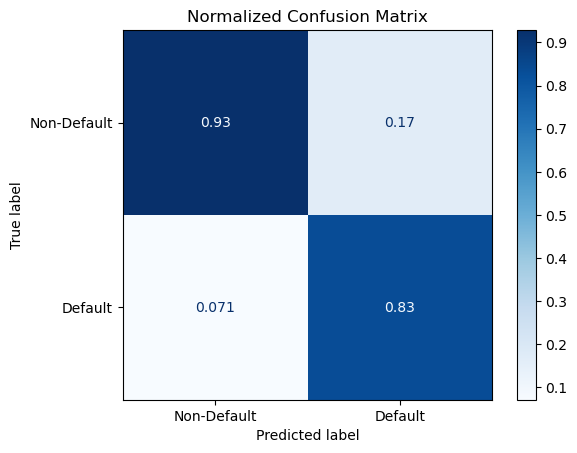

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test,
                                    display_labels=['Non-Default','Default'],
                                    cmap='Blues', normalize='pred')
plt.title('Normalized Confusion Matrix')
plt.show()

While the model significantly reduced false positives (default precision improved from 51% to 83%), the slight drop in recall is suboptimal for risk management. Since capturing true defaults is our top priority, we will prioritize models that maximize recall while maintaining reasonable precision.

Now let's try different boosting models for this problem

In [14]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/99/19/e2544328cb7be70d7f73a7660ecce3a63b40282ff1a344c44c2faeef9586/xgboost-3.0.4-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 325.1 kB/s eta 0:02:55
   ---------------------------------------- 0.1/56.8 MB 456.6 kB/s eta 0:02:05
   ---------------------------------------- 0.1/56.8 MB 502.0 kB/s eta 0:01:53
   ---------------------------------------- 0.2/56.8 MB 655.4 kB/s eta 0:01:27
   ---------------------------------------- 0.2/56.8 MB 762.6 kB/s eta 0:01:15
   ---------------------------------------- 0.3/56.8 MB 785.2 kB/s eta 0:01:13
   ---------------------------------------- 0.3/56.8 MB 824.9 kB/s eta 0:01:09
   -----------------------------

In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    scale_pos_weight=4,  
    eval_metric='aucpr', 
    max_depth=5,
    subsample=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5094
           1       0.78      0.81      0.79      1421

    accuracy                           0.91      6515
   macro avg       0.86      0.87      0.87      6515
weighted avg       0.91      0.91      0.91      6515



Much better, now, let's try LGBM

In [17]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/5e/23/f8b28ca248bb629b9e08f877dd2965d1994e1674a03d67cd10c5246da248/lightgbm-4.6.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 660.6 kB/s eta 0:00:03
   - -------------------------------------- 0.0/1.5 MB 495.5 kB/s eta 0:00:03
   - -------------------------------------- 0.1/1.5 MB 550.5 kB/s eta 0:00:03
   - -------------------------------------- 0.1/1.5 MB 550.5 kB/s eta 0:00:03
   - -------------------------------------- 0.1/1.5 MB 281.8 kB/s eta 0:00:05
   ----- ---------------------------------- 0.2/1.5 MB 737.3 kB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.5 MB 722.1 kB/s eta 0:00:02
   -------- ------------------------------- 0.3/1.5 MB 895.6 kB/s eta 0:00:02
   --------- ------------------

In [18]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    class_weight='balanced',  
    objective='binary',      
    boosting_type='gbdt',    
    n_estimators=100,       
    max_depth=10,            
    learning_rate=0.03,     
    metric='aucpr',         
    random_state=42
)

lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]


print(classification_report(y_test, y_pred_lgbm, target_names=['Non-Default', 'Default']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lgbm):.3f}")

C:\Users\plotv\anaconda3\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5686, number of negative: 20373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 26059, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.93      0.97      0.95      5094
     Default       0.87      0.75      0.81      1421

    accuracy                           0.92      6515
   macro avg       0.90      0.86      0.88      6515
weighted avg       0.92      0.92      0.92      6515

ROC-AUC: 0.931


And now let's try CatBoost

In [20]:
!pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/0e/91/e60d80ce72e5fce94fa672908b1f7ffb881701027130b7d637bb6b6561a4/catboost-1.2.8-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/91/4c/e0ce1ef95d4000ebc1c11801f9b944fa5910ecc15b5e351865763d8657f8/graphviz-0.21-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB 330.3 kB/s eta 0:05:11
   ---------------------------------------- 0.0/102.5 MB 330.3 kB/s eta 0:05:11
   ---------------------------------------- 0.1/102.5 MB 491.5 kB/s eta 0:03:29
   ---------------------------------------- 0.1/102.5 MB 722.1 kB/s eta 0:02:22
   ---------------------------------------- 0.2/102.5 MB 1.0 MB/s eta 0:01:39
   ---------------------------------------- 0.3/102.5 MB 1.2 MB/s eta 0:01:29
   ----------------------------------------

In [22]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

catb = CatBoostClassifier(
    auto_class_weights='Balanced',  
    eval_metric='AUC',             
    depth=5,                       
    iterations=200,                
    learning_rate=0.05,
    subsample=0.8,
    random_seed=42,
    verbose=0                     
)

catb.fit(X_train, y_train)

y_pred = catb.predict(X_test)
y_proba = catb.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")



Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.93      0.94      0.94      5094
     Default       0.78      0.76      0.77      1421

    accuracy                           0.90      6515
   macro avg       0.86      0.85      0.86      6515
weighted avg       0.90      0.90      0.90      6515

ROC-AUC: 0.927


In [27]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

Comparing 3 different boostings, we can see that XGBoost does the best job with our task, so we'll take it for further improvement and move on to optimizing hyperparameters. To optimize hyperparameters, we need to use the f2-score to take into account that, due to business logic, the ability to manage real defaults is a priority for us.

In [46]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import fbeta_score, classification_report
import numpy as np
optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial):
    params = {
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 3, 5),  
        'max_depth': trial.suggest_int('max_depth', 3, 7),  
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),  
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'eval_metric': 'aucpr',  
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = XGBClassifier(**params)
    
   
    y_proba = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    
    
    y_pred = (y_proba > 0.5).astype(int)  
    return fbeta_score(y_train, y_pred, beta=2)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")


best_model = XGBClassifier(**study.best_params, eval_metric='aucpr', random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))



Лучшие параметры:
scale_pos_weight: 3.7568365163115782
max_depth: 7
subsample: 0.8611185193934687
learning_rate: 0.15392049977858707
colsample_bytree: 0.9102638596652478
reg_alpha: 0.18180389042698344
reg_lambda: 0.5627059288013503
min_child_weight: 3

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5094
           1       0.83      0.79      0.81      1421

    accuracy                           0.92      6515
   macro avg       0.88      0.87      0.88      6515
weighted avg       0.92      0.92      0.92      6515



In [51]:
y_pred_optimal = (y_proba >= 0.5).astype(int)

print(classification_report(y_test, y_pred_optimal))


Classification Report с оптимальным порогом:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5094
           1       0.78      0.82      0.80      1421

    accuracy                           0.91      6515
   macro avg       0.86      0.88      0.87      6515
weighted avg       0.91      0.91      0.91      6515



Here we got a model that, at a threshold of 0.5, gives a slightly better result than the one originally used by xgboost. At the same time, it should be borne in mind that the further selection of the threshold value should be selected based on exactly what losses the bank incurs in case of errors of each type.

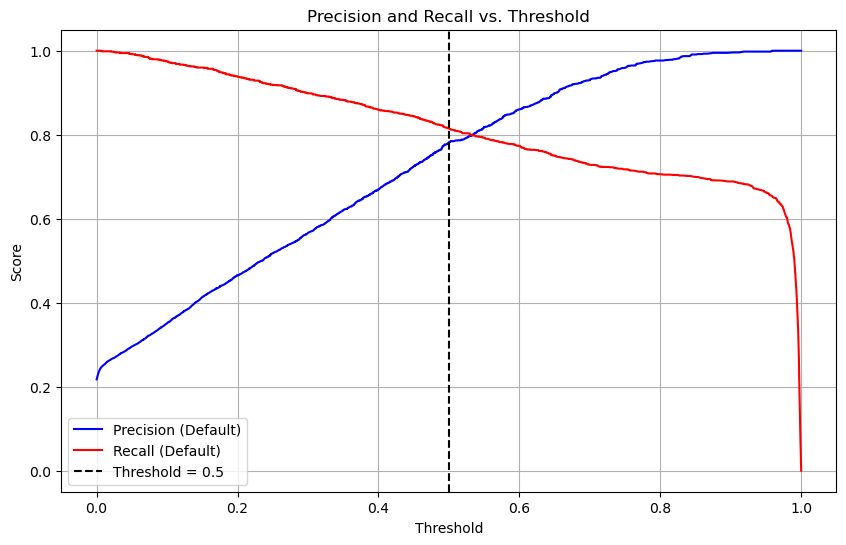

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision (Default)', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall (Default)', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()

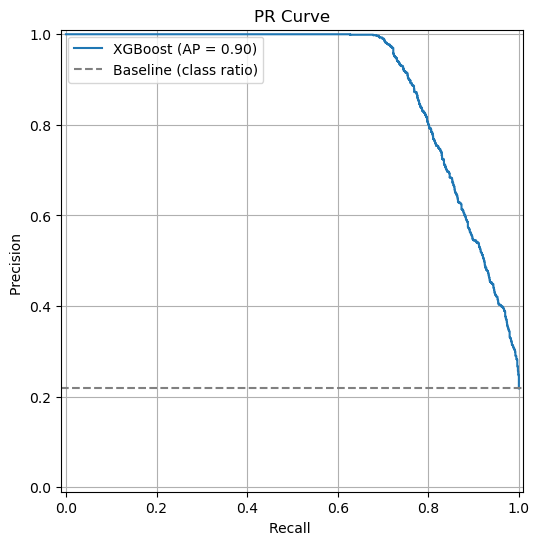

In [56]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_proba = best_model.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(figsize=(10, 6))
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=ax, name='XGBoost')
plt.axhline(y=0.22, color='gray', linestyle='--', label='Baseline (class ratio)')
plt.title('PR Curve')
plt.xlabel('Recall ')
plt.ylabel('Precision ')
plt.legend()
plt.grid()
plt.show()